# **LAB 3: Comparative Inference Benchmarking on ARM Server and Edge Devices**

## Introduction

Welcome to Lab 3 in our series on **Optimizing Generative AI Workloads with ARM Processors**! In this lab, we shift our focus to evaluating the performance constraints of generative AI inference between ARM-based server and edge devices. Specifically, we'll use the **OpenELM-3B** model alongside the popular **llama.cpp** framework to benchmark and compare inference characteristics on two different ARM environments: a high-performance Graviton server based on the Neoverse processor and a comparatively resource-constrained Raspberry Pi5.

Throughout this lab, you will:

- **Benchmark thoughput Metrics**: Measure and compare the overall inference thoughput of both the prefill and generation stages of large language model transformers.
- **Evaluate Memory Constraints**: Analyze how the OpenELM-3B model's memory constraints varies between an ARM server and an ARM-based edge device.
- **Compare Edge and Server Constraints**: Understand the practical limitations and trade-offs when deploying large language models on different ARM CPUs, from powerful server-class processors to limited edge devices.
- **Utilize llama.cpp Framework**: Leverage the llama.cpp framework for efficient model inference and performance measurement, allowing for cross-device comparisons.

This lab will guide you through setting up the necessary environments, running inference benchmarks on both the Raspberry Pi and Graviton server, and interpreting the results. By the end of the lab, you'll gain insights into:

- How hardware differences affect model performance
- Strategies for optimizing inference on both server and edge ARM devices
- Best practices for deploying large language models across diverse ARM architectures


### **Lab Objectives**

1. **Set Up Diverse ARM Environments**  
   Prepare and configure both a Raspberry Pi (edge device) and an ARM Graviton server for inference benchmarking with the OpenELM-3B model and llama.cpp framework.

2. **Benchmark Latency Metrics**  
   Measure key performance indicators, including tokens per-second throughput for both prompt-processing and token generation phases. 

3. **Analyze Memory Consumption**  
   Monitor and compare memory utilization during model inference to assess resource constraints on server and edge devices.

4. **Compare Performance Constraints**  
   Understand the practical implications of deploying large language models on resource-constrained edge devices versus powerful server environments. Identify bottlenecks and optimization opportunities for each scenario.

5. **Document Findings and Insights**  
   Compile your observations, compare the differences in performance, and suggest strategies to mitigate limitations on edge devices while leveraging server capabilities.

### **What You Will Learn**

- **ARM Environment Configuration**:  
  Learn how to set up and configure both ARM-based server and edge devices for AI inference benchmarking.

- **Performance Metric Analysis**:  
  Measure throughput metrics, including prompt processing and token generation rates, in tokens per second (t/s), to evaluate LLM inference efficiency.

- **Memory Utilization Insights**:  
  Strictly, we don't measure memory consumption in this lab, but rather infer whether memory is a bottleneck by looking at how performance scales with number of threads.

- **Hardware Trade-Offs and Optimization**:  
  Explore the performance constraints and trade-offs between resource-constrained edge devices and high-performance server-class ARM processors, and learn strategies to mitigate these limitations.


### **Prerequisites**

- **Basic Understanding of Linux**: Familiarity with Linux command-line operations and system configuration.
- **Experience with C/C++ and Python Programming**: Ability to modify, compile, and execute code with the help of instructions.
- **Fundamentals of AI Inference**: Knowledge of how transformer inference works in large language models.
- **Completion of Labs 1 and 2 (Recommended)**: Prior experience with ARM intrinsics, quantization, and performance benchmarking for generative AI workloads.
- **Completion of Chapters 1, 2, 3 and 4**: Understanding of the concepts of KleidiAI microkernels, quantization, and performance benchmarking will be useful.


**By the end of this lab**, you will have a comprehensive understanding of how ARM server and edge CPUs handle inference for large language models like OpenELM-3B. You will be equipped with the skills to benchmark and analyze prompt processing throughput, decoding performance, and memory consumption, enabling you to make informed decisions when deploying AI models across diverse ARM architectures.

---

# 1. Setting Up the Raspberry Pi for Inference Benchmarking

Before proceeding, ensure you have completed the [Lab 1 setup script](#) on your Raspberry Pi. If not, start by running the setup script:

```bash
./setup_pi5.sh
```

Once the script completes, activate the newly created virtual environment:

```bash
source pi5_env/bin/activate
```

This ensures that all required packages for the lab are preinstalled.

### Building the llama.cpp Inference Framework

If you haven't already, download and build the [llama.cpp](https://github.com/ggerganov/llama.cpp) inference framework with ARM CPU optimizations:

1. **Clone this repository:**

   ```bash
   git clone https://github.com/ggerganov/llama.cpp
   ```

2. **Configure the build:**

   ```bash
   cmake -B llama.cpp/build -S llama.cpp -DCMAKE_CXX_FLAGS="-mcpu=native" -DCMAKE_C_FLAGS="-mcpu=native"
   ```

3. **Compile the framework:**

   ```bash
   cmake --build llama.cpp/build --config Release -j$(nproc) -v
   ```

These commands build the framework optimized for your ARM CPU.

### Downloading the OpenELM-3B Model Weights

Next, download the large language model weights from Hugging Face. Follow these steps:

1. Create a Python file named `download_openelm.py` in the root directory with the following content:

   ```python
   from huggingface_hub import snapshot_download

   # Specify the target directory for downloading the model
   target_directory = "models/hf_models/OpenELM-3B-Instruct"

   # Download a snapshot of the model repository
   snapshot_download(
       repo_id="apple/OpenELM-3B-Instruct",
       local_dir=target_directory,
       revision="main",  # Optional: specify a branch, tag, or commit hash
       local_dir_use_symlinks=False  # Set to True if you want symlinks instead of file copies
   )
   # Download a snapshot of the tokenizer
   snapshot_download(
        repo_id="meta-llama/Llama-2-7b-hf",
        local_dir="models/tokenizer/llama2",
        allow_patterns=["tokenizer.model", "tokenizer_config.json", "special_tokens_map.json"],
        local_dir_use_symlinks=False
    )
   ```

2. Run the script to start downloading the model weights:

   ```bash
   python download_openelm.py
   ```

   followed by the following to copy the tokenizer into the model directory
    ```bash
    cp models/tokenizer/llama2/* models/hf_models/OpenELM-3B-Instruct/
    ```

   > **Note:** The download may take around 20 minutes, depending on your internet speed, as the model is large (~3 billion parameters).

### Converting and Quantizing the Model

Once the model is downloaded, convert it to the GGUF format and quantize it for inference:

1. **Convert the model to GGUF format:**

   ```bash
   mkdir -p models/gguf_models

   python llama.cpp/convert_hf_to_gguf.py models/hf_models/OpenELM-3B-Instruct/ \
       --outfile models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       --outtype f16
   ```

2. **Quantize the model using llama-quantize:**

   The quantization process reduces the model's size and computational requirements, which can improve inference speed on resource-constrained devices like the Raspberry Pi. Two types of quantization are demonstrated here:
   
   - **Q8_0 Quantization:** This reduces the model to 8-bit precision, balancing model size and performance. It typically offers faster inference with a moderate impact on accuracy.
   - **Q4_0 Quantization:** This reduces the model further to 4-bit precision, providing greater speed and memory savings at the expense of some accuracy.

   For Q8_0 quantization:
   ```bash
   llama.cpp/build/bin/llama-quantize \
       models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf Q8_0
   ```

   For Q4_0 quantization:
   ```bash
   llama.cpp/build/bin/llama-quantize \
       models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf Q4_0
   ```

### Prompting the Model

After quantization, you can prompt the different models. For example, to use the Q8_0 quantized model:

```bash
llama.cpp/build/bin/llama-cli \
    -m models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf \
    -p "Could you write a very simple program in C++ to print 'Hello, World!' in less than 10 lines of code?"
```

Follow similar steps for other prompts or to test the Q4_0 model. This setup process on the Raspberry Pi allows you to benchmark LLM inference on an edge device and later compare performance with an ARM Graviton server.


---

## 2. Setting Up the AWS Arm Graviton Server for Inference Benchmarking

If you have not already followed these steps in Lab 2, start by creating an AWS account and logging in as the root user. Next, set up an EC2 instance using a Graviton instance, based on the Arm Neoverse processor by following these steps:

1. Search for **EC2** in the AWS Management Console and click on **Launch Instance**.
2. Choose your operating system (AMI). Select **Ubuntu** and toggle the architecture box to **arm64**.
3. For the instance type, select a **m7g.xlarge** and allocate **32 GB** of persistent storage.
4. Launch the instance. Once the instance is created, click **Connect** to get the SSH command. It will look similar to:
   ```bash
   ssh -i "your-key.pem" ubuntu@instance-name.compute.amazonaws.com
   ```
5. Use the provided SSH command and run it in a terminal to connect to the instance.

### Setting Up the Server Environment

Once connected:

1. Clone this repository:
   ```bash
   git clone https://github.com/arm-university/AI-on-Arm/
   ```
2. Change directory and run the server setup script:
   ```bash
   cd AI-on-Arm
   ./setup_graviton.sh
   ```

### Building the llama.cpp Inference Framework

After setting up the server environment, clone and build the `llama.cpp` framework:

1. **Clone the repository:**
   ```bash
   git clone https://github.com/ggerganov/llama.cpp
   ```
2. **Configure the build:**
   ```bash
   cmake -B llama.cpp/build -S llama.cpp -DCMAKE_CXX_FLAGS="-mcpu=native" -DCMAKE_C_FLAGS="-mcpu=native"
   ```
3. **Compile the framework:**
   ```bash
   cmake --build llama.cpp/build --config Release -j$(nproc) -v
   ```

### Downloading the OpenELM-3B Model Weights

Assuming you've already created the `download_openelm.py` file from Section 1, proceed with:

1. Activate the virtual environment:
   ```bash
   source graviton_env/bin/activate
   ```
2. Run the download script:
   ```bash
   python scripts/download_openelm.py
   ```

### Converting and Quantizing the Model

Once the model has been downloaded:

1. **Convert the model to GGUF format:**
   ```bash
   mkdir models/gguf_models/
   python llama.cpp/convert_hf_to_gguf.py models/hf_models/OpenELM-3B-Instruct/ \
       --outfile models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       --outtype f16
   ```

2. **Quantize the model:**

   For **Q8_0 quantization:**

   
   ```bash
   llama.cpp/build/bin/llama-quantize \
       models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf Q8_0
   ```
   
   <br> 
   
   For **Q4_0 quantization:**

   
   ```bash
   llama.cpp/build/bin/llama-quantize \
       models/gguf_models/OpenELM-3B-Instruct-f16.gguf \
       models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf Q4_0
   ```

---

## 3. Benchmarking LLM Inference on Server and Edge


Great! If you've completed all the previous steps, you should now have a compiled `llama.cpp` inference framework on both your local Raspberry Pi and a remote ARM Graviton server. Each setup includes the 3B OpenELM model available in floating-point 16 (f16), Int8 (`Q8_0`), and Int4 (`Q4_0`) precisions.


To compare performance between these devices, we’ll focus on throughput-based metrics that can be used to estimate key inference latencies. Two directly measurable metrics provided by `llama.cpp` are:

- **Prompt Processing Rate**, measured in tokens per second (t/s): This metric indicates how quickly the LLM processes the input prompt before generating any output. A higher rate implies better efficiency when handling large prompts.

- **Token Generation Rate**, also in tokens per second (t/s): This measures how quickly new tokens are produced autoregressively during generation. This rate reflects the performance of the decoder and can benefit from optimizations like KV caching.

Although `llama.cpp` does not report latency metrics directly, you can approximate them using these throughput values. For example:
- **Time-to-first-token (TTFT)** ≈ (number_of_prompt_tokens / prompt_processing_rate) + (1 / token_generation_rate)
- **Total inference latency** ≈ (number_of_prompt_tokens / prompt_processing_rate) + (number_of_output_tokens / token_generation_rate)

These derived metrics give insight into user-perceived latency and system responsiveness.

#### Benchmarking on Raspberry Pi
To measure the throughput metrics, you can use the llama-bench tool provided by llama.cpp. For example, to evaluate performance locally, you can run the below cell on the raspberry pi:

In [1]:
!llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf -p 4 -n 2

| model                          |       size |     params | backend    | threads |            test |                  t/s |
| ------------------------------ | ---------: | ---------: | ---------- | ------: | --------------: | -------------------: |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       4 |             pp4 |         23.66 ± 1.64 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       4 |             tg2 |          6.58 ± 0.02 |

build: 600e3e9b (5707)


Your output should look like this:

| model                          |       size |     params | backend    | threads |          test |                  t/s |
| ------------------------------ | ---------: | ---------: | ---------- | ------: | ------------: | -------------------: |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       4 |           pp4 |         21.29 ± 0.23 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       4 |           tg2 |          5.31 ± 0.26 |

build: 1d850433 (4488)

In this example, there are two types of tests: **pp4** and **tg2**.

- **pp4**: This indicates the prompt processing speed measure in tokens per second. The number `4` in `pp4` represents the 4 input tokens used, specified by the `-p 4` argument passed to `llama-bench`.

- **tg2**: This indicates the token generation speed in tokens per second. The number `2` in `tg2` represents the number of tokens generated, specified by the `-n 2` argument passed to `llama-bench`.

We can now run a number of experiments. Remember in lab 2, we were able to partition matrix multiplications into different piecies of work, each of them able to be parallelized across KleidiAI microkernels. We can also achieve this parallelization in the llama.cpp framework by using the --threads argument to the llama-bench tool. Let's setup a benchmark file that will measure the prompt processing and token generation metrics accross different numbers of threads. You can do that by executing the below script. 


In [2]:
%%writefile scripts/benchmark_openelm.sh
#!/bin/bash

# benchmark the floating point 16 model and write it into 
mkdir openelm_results
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/q4_pi_results.txt
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/q8_pi_results.txt 

# NOTE: we are not benchmarking f16 on Raspberry Pi5 as the benchmark takes too long
# llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-f16.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/f16_pi_results.txt 

Writing scripts/benchmark_openelm.sh


In [3]:
!chmod +x ./scripts/benchmark_openelm.sh
!./scripts/benchmark_openelm.sh

mkdir: cannot create directory ‘openelm_results’: File exists
| model                          |       size |     params | backend    | threads |            test |                  t/s |
| ------------------------------ | ---------: | ---------: | ---------- | ------: | --------------: | -------------------: |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       1 |            pp12 |         11.96 ± 0.01 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       1 |             tg6 |          6.15 ± 0.00 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       2 |            pp12 |         22.64 ± 0.58 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       2 |             tg6 |          7.20 ± 0.03 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CPU        |       3 |            pp12 |         28.54 ± 0.04 |
| openelm 3B Q4_0                |   1.62 GiB |     3.04 B | CP

#### Benchmarking on Graviton

Once the above cell finishes, you will have computed the throughput metrics on your Raspberry Pi. Now, we will compute the same metrics on a remote Graviton server for comparison. To do this, we need to create a benchmark script on the remote server that performs the same experiments.

Ensure you are connected to the Graviton server via SSH in the terminal. You should have done this in section 2 when you setup the graviton server. Once you have done that you should open a new script file for benchmarking:

```bash
nano scripts/benchmark_openelm.sh
```

Paste the contents of the benchmark script below into this file.

```bash
#!/bin/bash
mkdir openelm_results
 
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-f16.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/f16_grav_results.txt 
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q8_0.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/q8_grav_results.txt 
llama.cpp/build/bin/llama-bench -m models/gguf_models/OpenELM-3B-Instruct-q4_0.gguf -p 12 -n 6 --threads 1,2,3,4 | tee openelm_results/q4_grav_results.txt 
```

To save and exit the file, press `CTRL + O`, then `Enter`, followed by `CTRL + X`.


Make the script executable:

```bash
chmod +x ./scripts/benchmark_openelm.sh
```

Run the benchmark script:

```bash
./scripts/benchmark_openelm.sh
```

Once the script has finished, copy the benchmark results back to your Raspberry Pi for further analysis and comparison by running the below command on your **PI**:

```bash
scp -i "your-key.pem" -r ubuntu@instance-name.compute.amazonaws.com:your/path/to/AI-on-Arm/openelm_results/ /your/path/to/local/AI-on-Arm/openelm_results/
```

Now you should have all of the local and server results on your local rasberry pi. Next we should parse those results into a pandas dataframe so that we can plot it easily. We can do that by running the below command. 

In [4]:
!python scripts/parse_results.py openelm_results/q8_pi_results.txt
!python scripts/parse_results.py openelm_results/q4_pi_results.txt

!python scripts/parse_results.py openelm_results/f16_grav_results.txt
!python scripts/parse_results.py openelm_results/q8_grav_results.txt
!python scripts/parse_results.py openelm_results/q4_grav_results.txt

Lets now load those pandas dataframes 

In [5]:
import pandas as pd 

df_pi_q8 = pd.read_csv("openelm_results/q8_pi_results.csv")
df_pi_q4 = pd.read_csv("openelm_results/q4_pi_results.csv")

df_grav_f16 = pd.read_csv("openelm_results/f16_grav_results.csv")
df_grav_q8 = pd.read_csv("openelm_results/q8_grav_results.csv")
df_grav_q4 = pd.read_csv("openelm_results/q4_grav_results.csv")

Now we have done that we should have a look at prompt processing throughput  

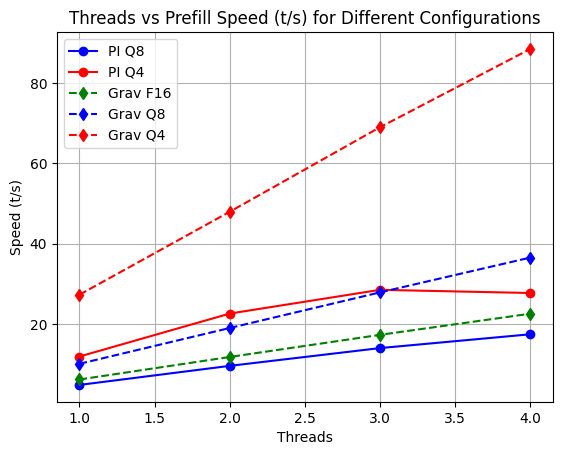

In [6]:
import matplotlib.pyplot as plt

# Filter data for tests starting with 'pp'
filtered_dfs = {
    "PI Q8": (df_pi_q8, 'blue', 'o', '-'),
    "PI Q4": (df_pi_q4, 'red', 'o', '-'),
    "Grav F16": (df_grav_f16, 'green', 'd', '--'),
    "Grav Q8": (df_grav_q8, 'blue', 'd', '--'),
    "Grav Q4": (df_grav_q4, 'red', 'd', '--'),
}

# Function to plot speed vs threads
def plot_speed_vs_threads(df, label, color, marker, linestyle):
    filtered_df = df[df['Test'].str.startswith('pp')]
    plt.plot(filtered_df['Threads'], filtered_df['Speed (t/s)'], 
             label=label, marker=marker, color=color, linestyle=linestyle)

# Plot each dataset
for label, (df, color, marker, linestyle) in filtered_dfs.items():
    plot_speed_vs_threads(df, label, color, marker, linestyle)

plt.xlabel('Threads')
plt.ylabel('Speed (t/s)')
plt.title('Threads vs Prefill Speed (t/s) for Different Configurations')
plt.legend()
plt.grid(True)
plt.show()




### **Graph Analysis: Thread Scaling and Bottlenecks**

This graph highlights key differences in how **thread count impacts throughput (tokens per second) during the prompt processing stage** for the Raspberry Pi and Graviton systems.

For **Graviton** (dashed lines), you should observe an almost perfect **linear increase in throughput** as the thread count increases, across all precision levels. This strongly suggests that **prompt processing is compute-bound rather than memory-bound** on Graviton. In other words, the primary bottleneck is the **computational workload** (such as multiply-add-accumulate operations) rather than memory access latency.

In contrast, for the **Raspberry Pi** (solid lines), throughput improvements become **sublinear** as more threads are added. This indicates that the **computation becomes memory-bound**, meaning the processor is increasingly limited by memory access speeds rather than raw compute power. The **Raspberry Pi 5 has only four CPU cores**, and its memory system becomes a bottleneck as more threads compete for bandwidth.

The key reason for this difference lies in the **memory architecture and cache hierarchy** of the two systems. The Raspberry Pi has **much smaller caches**, forcing it to access **slower system memory more frequently**, introducing latency and reducing efficiency. In contrast, the **Graviton server features larger and faster caches**, which can sustain the high memory bandwidth demands of the **3B model**, avoiding major slowdowns as thread count increases.

Additionally, if we look at the **single-threaded performance** (where the **x-axis=1**), we can see that the **Graviton server achieves significantly higher throughput than the Raspberry Pi**, even before scaling up with additional threads. This advantage is not only due to the **higher clock speed** of the Graviton CPU but also the presence of **specialized ARM CPU extensions** that the Raspberry Pi lacks. As covered in **Lab 2**, the Graviton processor includes **DotProd (Dot Product) and I8MM (Integer Matrix Multiplication) instructions**, which accelerate deep learning computations by optimizing tensor operations at the hardware level. These **optimized instructions enable more efficient matrix multiplications**, a key operation in transformer-based models, giving Graviton an edge even in single-threaded execution.

This distinction between **compute-bound vs. memory-bound performance**, along with the impact of **hardware-level optimizations**, highlights the scalability and efficiency differences between embedded ARM devices and high-performance ARM servers when running transformer-based models. 🚀

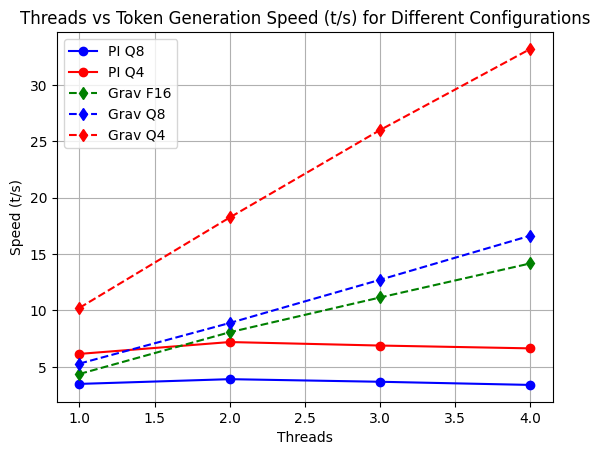

In [7]:
import matplotlib.pyplot as plt

# Define dataset mappings with color, marker, and linestyle
filtered_dfs = {
    "PI Q8": (df_pi_q8, 'blue', 'o', '-'),
    "PI Q4": (df_pi_q4, 'red', 'o', '-'),
    "Grav F16": (df_grav_f16, 'green', 'd', '--'),
    "Grav Q8": (df_grav_q8, 'blue', 'd', '--'),
    "Grav Q4": (df_grav_q4, 'red', 'd', '--'),
}

# Function to plot speed vs threads
def plot_speed_vs_threads(df, label, color, marker, linestyle):
    filtered_df = df[df['Test'].str.startswith('tg')]
    plt.plot(filtered_df['Threads'], filtered_df['Speed (t/s)'], 
             label=label, marker=marker, color=color, linestyle=linestyle)

# Loop through datasets and plot
for label, (df, color, marker, linestyle) in filtered_dfs.items():
    plot_speed_vs_threads(df, label, color, marker, linestyle)

plt.xlabel('Threads')
plt.ylabel('Speed (t/s)')
plt.title('Threads vs Token Generation Speed (t/s) for Different Configurations')
plt.legend()
plt.grid(True)
plt.show()


### **Graph Analysis: Token Generation Throughput and Bottlenecks**

In this graph, we observe that **token generation throughput on the Graviton server scales linearly with the number of processing threads**. This suggests that **token generation on Graviton is again compute-bound**, meaning that performance is primarily limited by operation throughput rather than memory access.

For the **Raspberry Pi**, however, you should see that the throughput (speed (t/s) on the graph) remains relatively **flat**, showing little to no improvement as additional threads are added.

The key reason for this difference lies in the computational intensity of these two phases:

- **Prompt processing is highly arithmetic-intensive**, as it requires computing attention across the entire input sequence at once. Each token in the prompt is processed **in parallel**, leading to a large number of floating-point operations per second (**FLOPS**) or tera operations per second (**TOPS**).
- **Token generation, in contrast, is inherently sequential**, with only **one token being generated at a time**. Thanks to the **key-value (KV) cache**, the transformer does not need to recompute attention over all previous tokens from scratch. Instead, it **only retrieves stored key and value activations** from earlier steps and computes attention over them. This significantly **reduces the number of arithmetic operations per token**, making token generation far less compute-intensive than prompt processing.

Because the **feed-forward layers in the transformer process each new token independently**, the overall FLOPS/TOPS demand is lower than in the prefill phase. However, token generation introduces **a higher ratio of memory reads to arithmetic operations**:
- The model must **fetch previously stored key-value activations** for attention calculations.
- It must also **load the neural network’s weights** to compute the feed-forward layers.
- As a result, **memory bandwidth becomes a key factor** in determining performance.

On **Graviton**, with its **higher memory bandwidth**, token generation remains **compute-bound**, as indicated by the continued increase in throughput with additional threads. The processor can efficiently fetch and process key-value activations while keeping arithmetic units fully utilized.

On the **Raspberry Pi**, however, memory bandwidth is significantly more constrained. Since token generation involves frequent memory accesses to retrieve cached activations, the system quickly becomes **memory-bound**. This explains why **adding more threads does not improve performance**—the bottleneck is not compute power but rather the ability to access memory quickly enough to feed the processor.

---

## 4. **Hands-on LLM Interaction**

To fully appreciate the difference in performance between the Raspberry Pi and the Graviton server, you should **interact with the models directly**.

#### **Running the Model Locally**
On your **Raspberry Pi**, open a terminal and run the following command:

```bash
python scripts/talk_to_openelm.py
```

At the same time, run the same command in your **SSH session connected to the Graviton server**:

```bash
python scripts/talk_to_openelm.py
```

#### **Things to Observe**
- **Response Speed**: Notice the difference in how quickly tokens are generated on each system.
- **Smoothness of Interaction**: Pay attention to delays when asking follow-up questions.
- **Effect of Precision**: Try modifying the model precision by changing the `-m` argument to a different quantized version (e.g., `q4_0` or `f16`) and see how it impacts performance.

By running the model on both platforms, you will get a **practical, hands-on understanding** of how compute-bound vs. memory-bound constraints impact real-world inference performance. 

Feel free to experiment with different model configurations and report your observations! 🚀

 
